# <center> Практические задания по цифровой обработке сигналов </center>
# <center> Вторая лабораторная работа </center>
# <center> Анализ сигналов </center>

In [54]:
import librosa
import numpy as np
import scipy
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib

# Запретим numpy выполнять деление на 0
np.seterr(divide='raise', invalid='raise')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [55]:
# Определим две функции для отрисовки сигнала.
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveshow(wav, sr=sr)

def draw_sig(frames, name=None, figsize=(14, 3)):
    # Отрисовка сигнала в виде "леденцов на палочке"
    plt.figure(figsize=figsize)
    plt.stem(frames)
    if name is not None:
        plt.legend([name])
    plt.xlabel("n")
    plt.ylabel("Energy")
    plt.show()


Создадим несколько простых сигналов. Они нам понадобятся для дальшейшего тестирования

In [56]:
signals = {}

### Единичный импульс

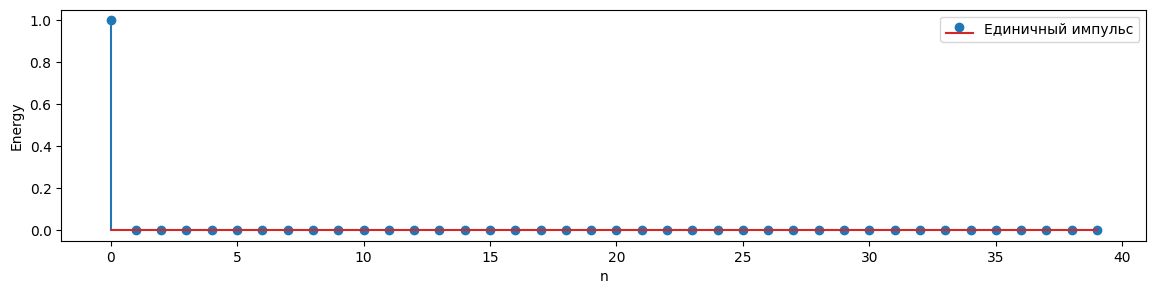

In [57]:
name = "Единичный импульс"
signals[name] = np.array([1] + [0]*39, dtype=float)
draw_sig(signals[name], name)

### Единичный скачок

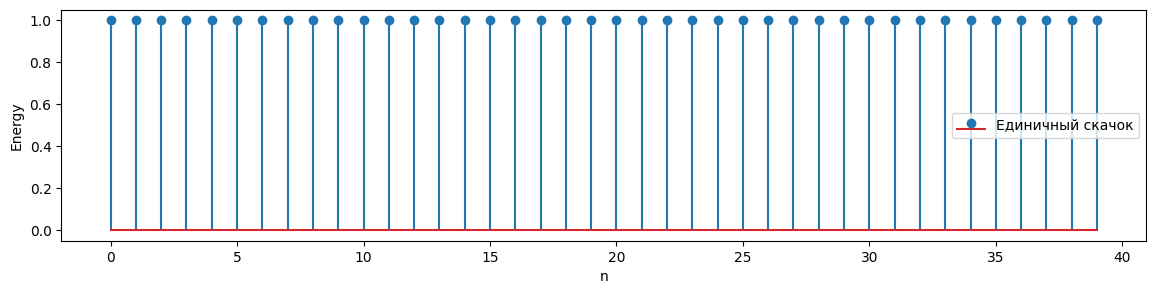

In [58]:
name = "Единичный скачок"
signals[name] = np.array([1]*40 ,dtype=float)
draw_sig(signals[name], name)

### Синус

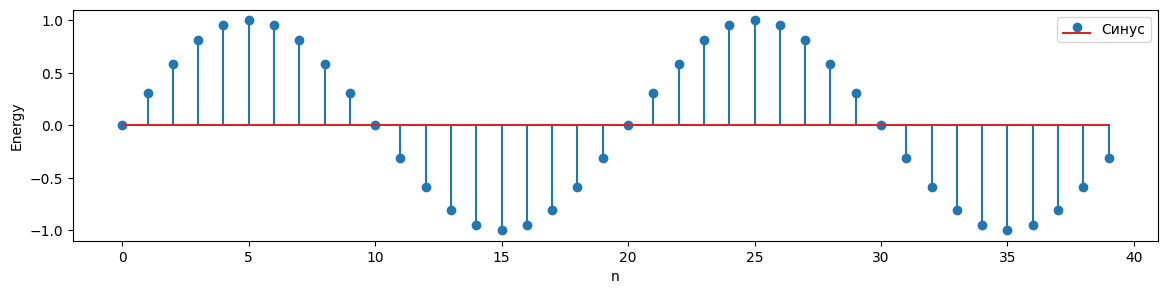

In [59]:
name = "Синус"
signals[name] = np.sin(np.pi * np.arange(40)/10)
draw_sig(signals[name], name)

### Шум

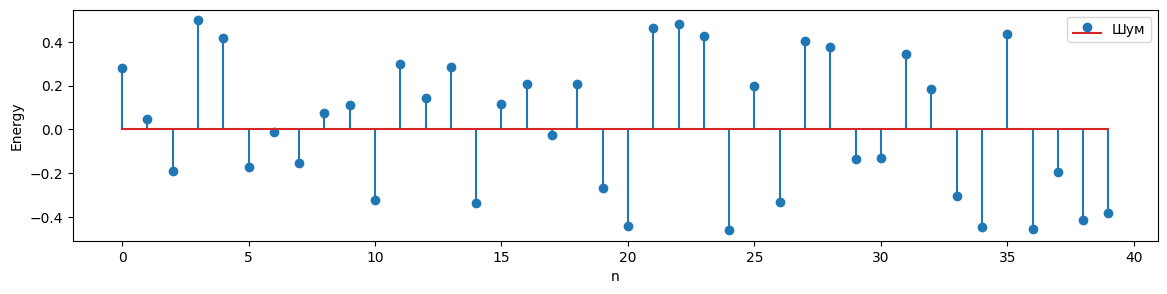

In [60]:
name = "Шум"
signals[name] = np.random.random(40)-0.5
draw_sig(signals[name], name)

-------------------------------
# Преобразование Фурье
Прежде, чем перейти к анализу сигналов, надо разобраться, что такое преобразование Фурье.
> Преобразование Фурье (символ ℱ) — операция, сопоставляющая одной функции вещественной переменной другую функцию вещественной переменной. Эта новая функция описывает коэффициенты («амплитуды») при разложении исходной функции на элементарные составляющие — гармонические колебания с разными частотами (подобно тому, как музыкальный аккорд может быть выражен в виде суммы музыкальных звуков, которые его составляют). [Wiki](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%B5%D0%BE%D0%B1%D1%80%D0%B0%D0%B7%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%A4%D1%83%D1%80%D1%8C%D0%B5)



Формула прямого дискретного преобразования Фурье (ДПФ, Discrete Fourier Transform, DFT):
$$ X_k = \sum_{n=0}^{N-1} x_{n} \cdot e^{-i \frac{2\pi}{N} k n} $$


# Задание 1 (2 балла)
Реализовать дискретное преобразование Фурье. Сравнить с реализацией *scipy.fft.fft*

In [61]:
def DFT(x):
    len_x = len(x)
    out = [0]*len_x # выходной массив
    for k in range(len_x):
        for n in range(len_x):
            out[k] += x[n] * np.exp(-1j*2*np.pi/len_x*k*n) # тут все просто, делаем 1 в 1 как в формуле, суммируем по n для каждого k
    return np.array(out)

    raise NotImplementedError()

Сравнение с библиотекой scipy:

In [62]:
def test_DTF(x, transform=DFT):
    scipy_result = scipy.fft.fft(x)
    curr_result = transform(x)
    if scipy_result.shape != curr_result.shape:
        print("TEST_FAILED")
        print(f"Your spectrogram shape is {curr_result.shape}. "
              f"Scipy spectrogram shape is {scipy_result.shape}")
        return -1
    if not np.allclose(curr_result, scipy_result):
        print("TEST FAILED")
        print(f"scipy spectrogram: {scipy_result}")
        print(f"Your DTF spectrogram: {curr_result}")
        print(f"Average diff is {np.mean(np.abs(scipy_result - curr_result))}")
        return -2
    print("TEST PASSED")
    return 0

for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST PASSED
Checking 'Синус'
TEST PASSED
Checking 'Шум'
TEST PASSED
All ok!


Класическое ДПФ имеет существенный недостаток - сложность алгоритма $O(N^2)$. На данный момент существуют чуть более сложные реализации преобразования Фурье, которые избавляются от квадратичной сложности. Например, алгоритм быстрого преобразования Фурье (Fast Fourier Transform, FFT) имеет сложность $O(N log(N))$, что делает его значительно более быстрым на длинных последовательностях.

# Задание 1.1* (1 балл)
Реализовать быстрое преобразование Фурье. Сравнить с scipy.fft.fft

**Подсказка:** учтите, что для БПФ нам нужно, чтобы количество отсчетов сигнала было степенью двойки

In [63]:
def FFT(x):
    N = len(x)
    if np.log2(N) == int(np.log2(N)):
        print('N must be a power of 2')
        return
    W = np.exp(-2j*np.pi*np.arange(N)/N) # экспонента для расчета как в обычном DFT
    out = np.zeros(N, dtype=np.complex128) # выходной массив
    even, odd = 0, 0
    for i in range(N//2): # разделение на чет/нечет
        w = W**(2*i)
        even = even + x[2*i]*w
        odd = odd + x[2*i+1]*w
    for j in range(N//2): # основной алгоритм
        out[j] = even[j] + W[j]*odd[j]
        out[j+N//2] = even[j] - W[j]*odd[j]

    return out


    raise NotImplementedError()

In [64]:
for name, sig in signals.items():
    print(f"Checking '{name}'")
    assert test_DTF(sig, transform=FFT) == 0, "Check you implementation"
print("All ok!")

Checking 'Единичный импульс'
TEST PASSED
Checking 'Единичный скачок'
TEST PASSED
Checking 'Синус'
TEST PASSED
Checking 'Шум'
TEST PASSED
All ok!


Если вы изменяли длительность исходных сигналов, не забудьте вернуть их изначальную длительность

In [65]:
# YOUR CODE HERE

# Амплитудный и фазовый спектры
Поскольку преобразование Фурье определено в комплекстной области, анализировать результат напрямую проблематично. Для анализа сигналов принято разбивать результат преобразования Фурье на два спектра: амплитудный и фазовый. Амплитудный показывает, как меняется модуль сигнала, а фазовый - как меняется угол, образуемый на комплексной плоскости.
# Задание 2 (1 балл)

Реализовать функции построения амплитудного и фазового спектра

In [66]:
#функция построения амплитудного спектра
def get_amplitude_from_spec(spec):
    return abs(spec)

    raise NotImplementedError()

#функция построения фазового спектра
def get_phi_from_spec(spec):
    return(np.arctan2(spec.imag, spec.real))
    # или так:
    # return np.angle(spec)

    raise NotImplementedError()

In [67]:
def check_mean_var(sig, mean=None, var=None):
    if mean is not None and np.mean(sig) != mean:
        print(f"Bad mean. Expected {mean}, got {np.mean(sig)}")
        return False
    if var is not None and np.var(sig) != var:
        print(f"Bad var. Expected {var}, got {np.var(sig)}")
        return False
    return True

_spec = scipy.fft.fft(np.array([1]+[0]*10))
assert check_mean_var(get_amplitude_from_spec(_spec), 1.0, 0.0), \
    "Wrong Amplitude"
assert check_mean_var(get_phi_from_spec(_spec), 0.0, 0.0), \
    "Wrong Phase"


_spec = scipy.fft.fft(np.array([1]*10))
assert check_mean_var(get_amplitude_from_spec(_spec), 1.0, 9.0), \
    "Wrong  Amplitude"
assert get_amplitude_from_spec(_spec)[0] == 10, \
    "Wrong Amplitude"
assert get_phi_from_spec(_spec)[0] == 0, \
    "Wrong phase"

_spec = scipy.fft.fft(scipy.fft.ifft(np.array([0] + [10+5j]+[0]*6 + [10-5j])))
assert get_amplitude_from_spec(_spec).round(1)[1] == 11.2 , \
    "Wrong Amplitude. Make sure it is a complex number module."
assert get_phi_from_spec(_spec).round(1)[1] == 0.5 , \
    "Wrong Amplitude. Make sure it is an angle."


print("All OK!")

All OK!


Определим еще одну функцию для отрисовки. Теперь будем рисовать сигнал в частотной области

In [68]:
def draw_spec(spec, name=None, draw_A=True, draw_p=True, figsize=(14, 3)):
    if len(spec)<100:
        # Рисуем точки как "леденцы на палочках"
        draw_func = plt.stem
    else:
        # При большом N "леденцы" выглядят плохо,
        # Поэтому будем рисовать огибающую функцию
        draw_func = plt.plot

    if draw_A:
        plt.figure(figsize=figsize)
        plt.title("Amplitude spectrum")
        spec_A = get_amplitude_from_spec(spec)
        draw_func(spec_A)
        plt.ylabel("Magnitude")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()

    if draw_p:
        plt.figure(figsize=figsize)
        plt.title("Phase spectrum")
        phi = get_phi_from_spec(spec)
        draw_func(phi)
        plt.ylabel("Radian")
        plt.xlabel("n")
        if name is not None:
            plt.legend([name])
        plt.show()
    return

# Задание 2.1 (0.5 балла)
Постройте спектры для всех сигналов из коллекции signals и ответьте на вопросы:
<!-- 1. Почему амплитуда всех гармоник единичного импульса равна единице?
1. Какие выводы можно сделать смотря на амплитудный спектр? А на фазовый?
1. Как перевести номер отсчета в частоту?  
1. Что в фазовом спектре является полезной информацией, а что - шумом? Почему? -->

### Визуализация:

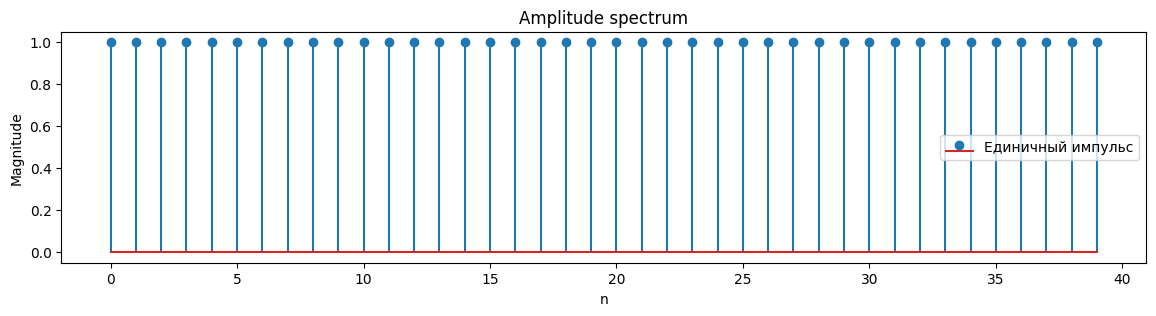

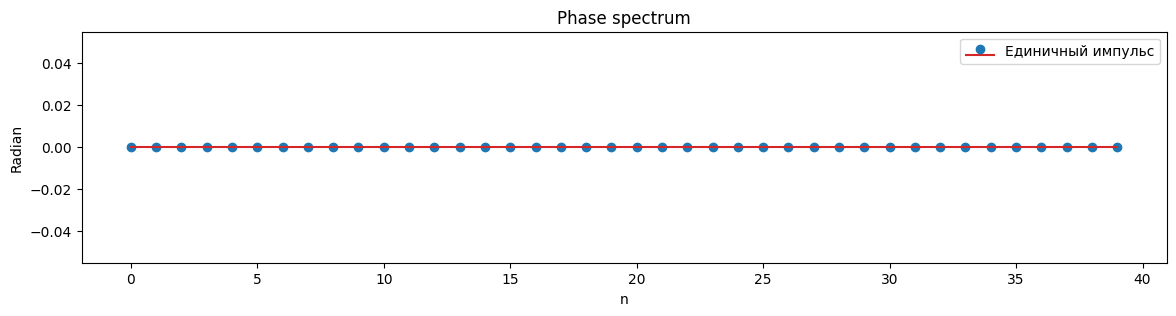

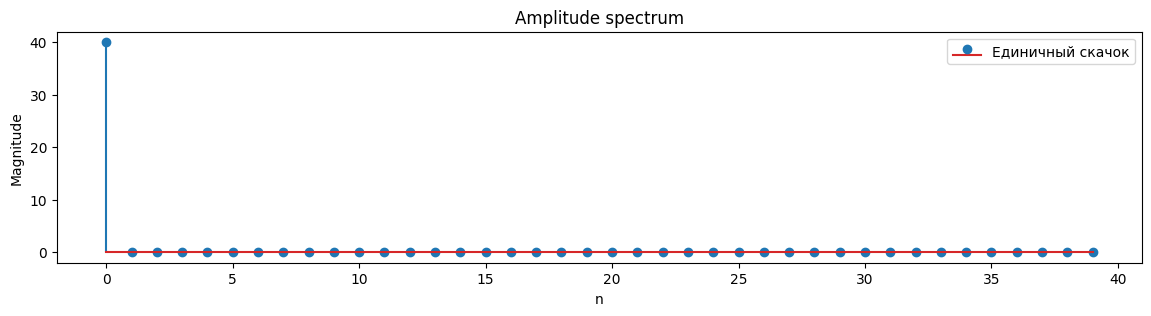

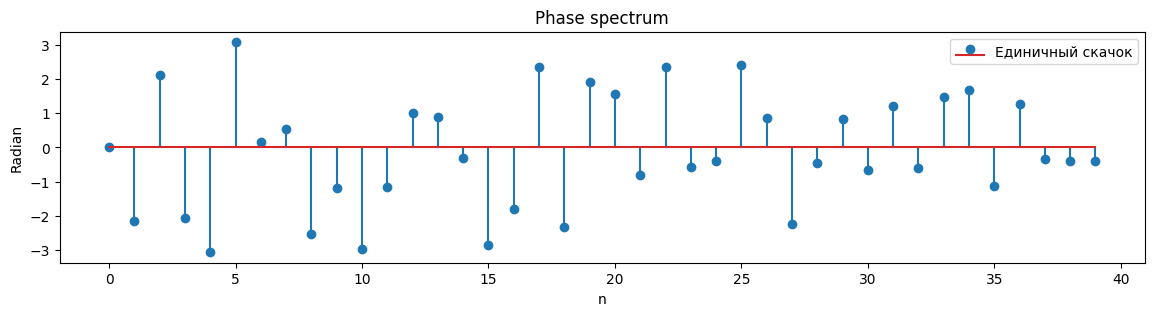

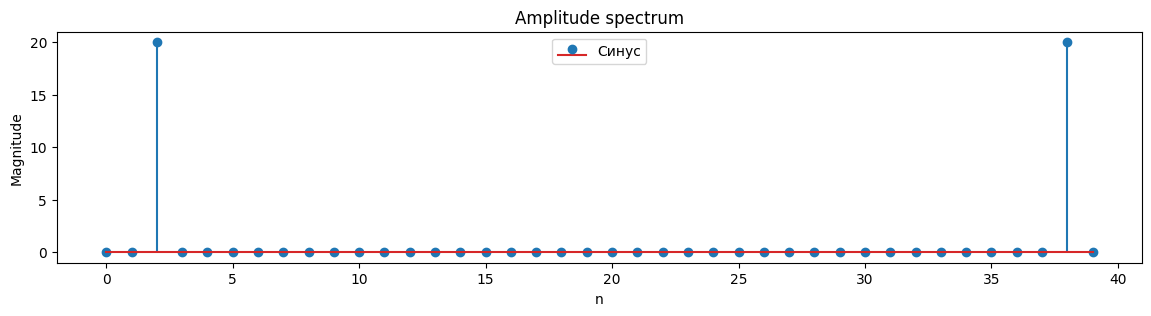

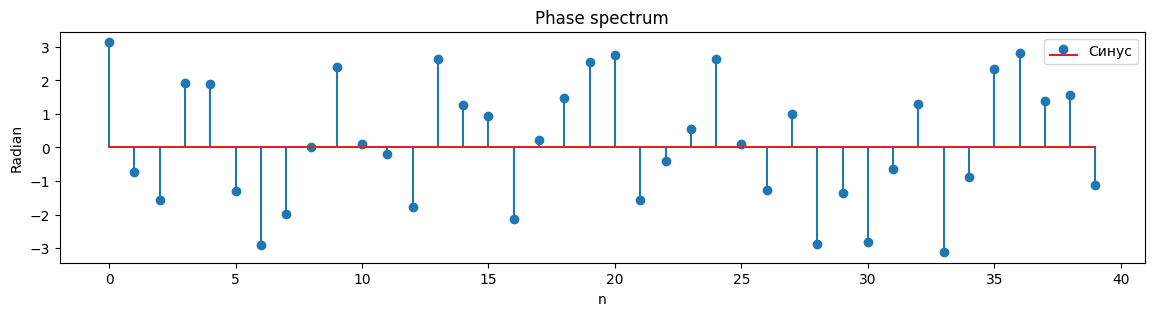

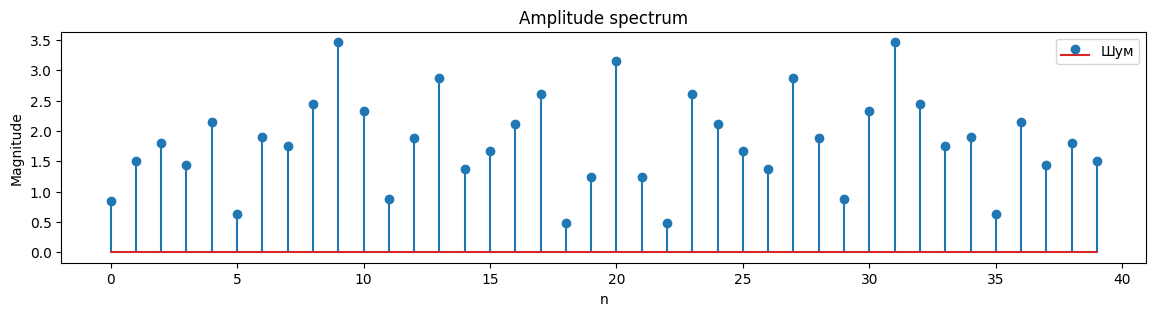

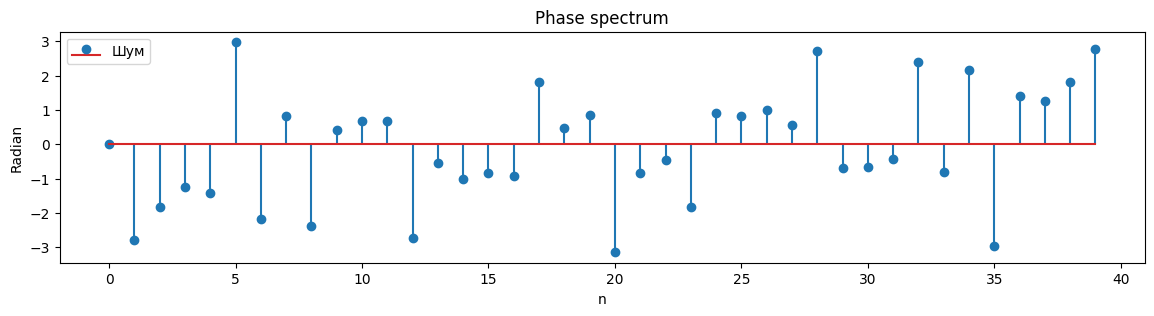

In [69]:
names = ["Единичный импульс", "Единичный скачок", "Синус", "Шум"]
for name in names:
    draw_spec(DFT(signals[name]), name=name, draw_A=True, draw_p=True, figsize=(14, 3))

### 1.Почему амплитуда всех гармоник единичного импульса равна константе?

Потому что преобразование Фурье единичной дельта функции = 1 (const) (разбирали на лекции)

### 2. Какие выводы можно сделать смотря на амплитудный спектр? А на фазовый?

Смотря на амплитудный спектр можно сказать, из каких гармоник (частот) состоит исходный сигнал и какой вклад в сигнал вносит каждая гармоника. Смотря на фазовый спектр можно сделать вывод, вещественный сигнал или комплексный (вещественный фазовый спектр антисимметричен). Спектр содержит сдвиги фаз одних гармоник относительно сдругих, то есть "структуру" сигнала (в двумерном случае это хорошо демонстрируется - можно поменять местами аплитудные спектры двух изображений, потом восстановить их, и все равно сможем увидеть очертания деталей, которые были на исходных сигналах до "свапа")

### 3. Как перевести номер отсчета в частоту?

Перевести номер k в частоту можно по следующей формуле:

$\frac{f_d}{N} \cdot k$ - частоту дискретизации поделить на число отсчетов и результат умножить на номер k

### 4. Что в фазовом спектре является полезной информацией, а что - шумом? Почему?

У дискретного сигнала период всегда является целым числом; общий вид сигнала:

$s(t) = A \cdot sin(\frac{2 \cdot \pi}{T}(t + t'))=A \cdot sin(\frac{2 \cdot \pi}{T}t + ϕ)$

t - дискретное, t' = 0,1,...

Возможно, $\phi$ (фаза) должна быть кратна $\frac{2 \cdot \pi}{T}$, иначе - шум

# Оконное преобразование Фурье
Преобразование Фурье делает переход из временной области в частотную, позволяя анализировать составляющие сигнал гармоники. Однако это не всегда удобно. В реальных сигналах зачастую составляющие их гармоники изменяются со временем. Например, каждая буква в слове имеет свой набор основных гармоник, и простое преобразование Фурье не сильно поможет нам определить, что было сказано. Для того, чтобы анализировать такие сигналы, обычно используется [Оконное преобразование Фурье](https://ru.wikipedia.org/wiki/Оконное_преобразование_Фурье). Такое преобразование позволяет анализировать гармоники сигнала в коротких промежутках времени и сохранить временную ось при построении спектрограммы.
# Задание 3 (2 балла)
Реализовать оконное преобразование Фурье (Short-time Fourier transform), пользуясь только библиотеками *numpy* и *scipy*. Сравнить с *librosa.stft*


In [70]:
def STFT(x, n_fft=2048, hop_length=512, window='hann'):
    # x - signal
    # n_fft - fft window size
    # hop_length - step size between ffts
    # window - window type. See scipy.signal.get_window
    # return spectrogram

    len_x = len(x) # длина исходного сигнала
    x = np.array([0]*(n_fft//2) + list(x)  + [0]*(n_fft//2)) # дополнили нулями, чтобы было "центрирование" как в либросе!
    M = int((len_x)//hop_length) + 1 # сколько окон со сдвигом hop поместится на len_x и еще одно,
    # #                                 чтобы полностью покрыть сигнал
    wind = scipy.signal.get_window(window, n_fft, fftbins=True) # сигнал-окно
    out = [] # выходной спектр
    for m in range(M): # передвигаемся окном по сигналу заранее посчитанное М раз
        x_wind = x[m*(hop_length):m*hop_length + n_fft] * wind # умножаем сигнал окна на то часть сигнала, которая в окне
        x_wind = scipy.fft.fft(x_wind) # делаем fft полученного сигнала
        out.append(x_wind[:n_fft//2+1]) # отрезаем симметричную часть спектра (чтобы было как в либросе)
    out = np.array(out)
    return out.T

# делал это задание часа 4, сначала долго фейлил на тесте "единичный импульс" Your shape (8, 16) != librosa stft shape (5, 21),
# а потом долго пытался понять, как нормально сделать центрирование =(((

    raise NotImplementedError()


In [71]:
def test_stft(x, n_fft=2048, hop_length=512, window='hann'):
    librosa_result = librosa.stft(x, n_fft=n_fft, hop_length=hop_length, window='hann', center=True)
    result = STFT(x, n_fft=n_fft, hop_length=hop_length, window='hann')
    if librosa_result.shape != result.shape:
        print(f"Your shape {result.shape} != librosa stft shape {librosa_result.shape} ")
        return -1
    if not np.allclose(librosa_result, result):
        print(f"Wrong results. Diff {np.abs(librosa_result-result)}")
        return -2
    return 0

for name, sig in signals.items():
    print(f"Checking '{name}'")
    for n_fft in (8, 4):
        for hop_length in (n_fft//4, n_fft//2):
            assert test_stft(sig, n_fft=n_fft, hop_length=hop_length)==0, \
                f"Test failed. Params n_fft {n_fft}. Hop_length {hop_length}"
    print("ok")
print("All ok!")

Checking 'Единичный импульс'
ok
Checking 'Единичный скачок'
ok
Checking 'Синус'
ok
Checking 'Шум'
ok
All ok!


Определим функцию для отрисовки

In [72]:
# Определим функцию для отрисовки (добавил немного своего функционала - регулировка масштаба рисунка для последнего задания)
def draw_stft(X, sr, figsize=(14, 5), x_lim=[], y_lim=[]):
    plt.figure(figsize=figsize)
    # X - комплекстная спектрограмма
    # Для получения энергии достаточно взять модуль
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    if x_lim !=[]:
        plt.xlim(x_lim)
    if y_lim != []:
        plt.ylim(y_lim)
    plt.show()

# Анализ сигналов
Теперь можно приступить к анализу звуковых сигналов.
Во время анализа сигналов нам понадобятся все определенные выше инструменты.


----------------------------------
## Анализ паровозного гудка
Начнем с простого сигнала, состоящего из нескольких основных гармоник и шума.

Загрузим аудио файл с паровозным гудком

Len is 82175 ( ). Sample rate is 22050


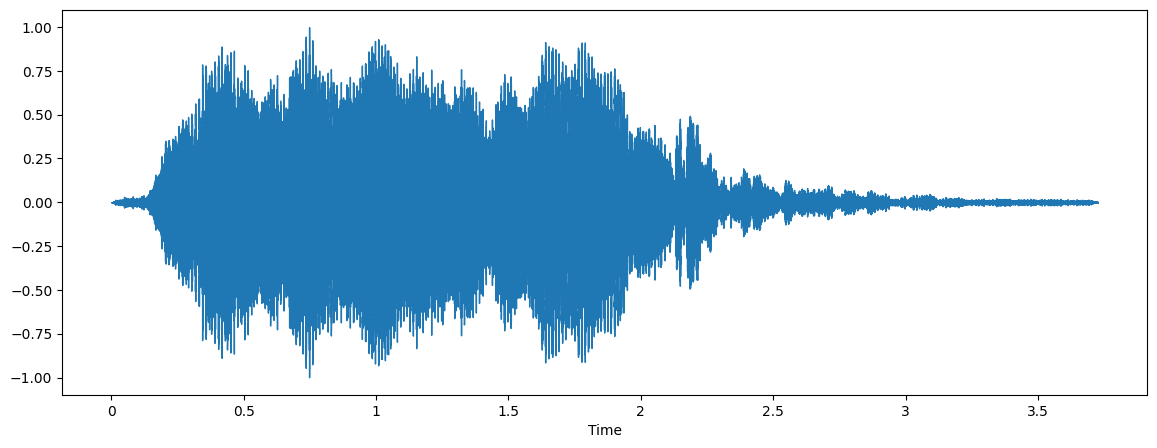

In [73]:
# Загрузим аудио файл с паровозным гудком
train_whistle, tw_sr = librosa.core.load("resources_train_whistle.wav")
print(f"Len is {len(train_whistle)} ( ). Sample rate is {tw_sr}")
player = ipd.Audio(train_whistle, rate=tw_sr)
ipd.display(player)
draw_waveform(train_whistle, sr=tw_sr)

Построим гудок паровоза в частотной области

Гудок паровоза в частотной области


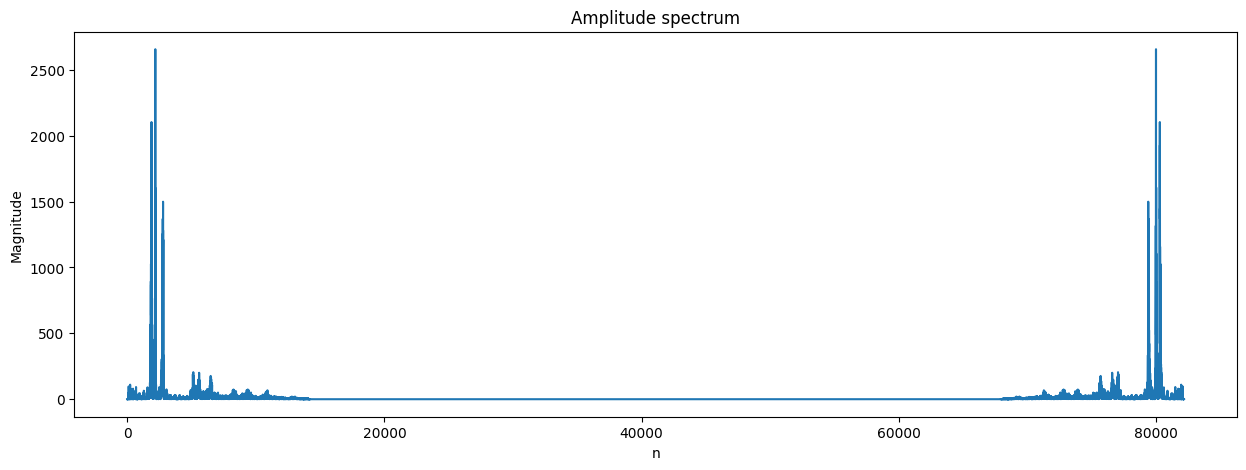

In [74]:
train_whistle_spec = scipy.fft.fft(train_whistle)
print("Гудок паровоза в частотной области")
draw_spec(train_whistle_spec, draw_p=False, figsize=(15,5))

# Задание 4 (2 балла)
Определите 3 основные гармоники паровозного гудка.

Ответ округлите до двух знаков после запятой.


Амплитудный спектр

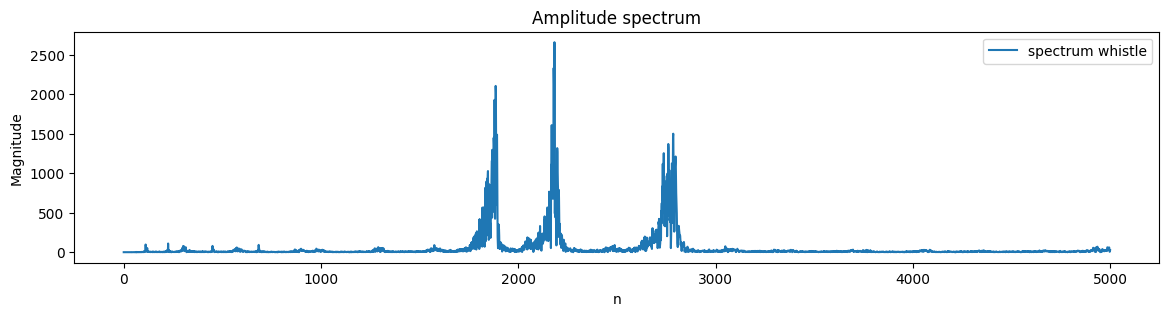

In [75]:
draw_spec(train_whistle_spec[:5000], name='spectrum whistle', draw_A=True, draw_p=False, figsize=(14, 3))


Найдем гармоники следующим образом:
- Находим k, соответствующее максимальной амплитуде
- Переводим k в частоту
- Округляем до двух знаков

### 1 гармоника

In [76]:
f_1 = round(np.argmax(abs(train_whistle_spec)[:2000])*(tw_sr/len(train_whistle)), 2)
print(f_1)

505.8


### 2 гармоника

In [77]:
f_2 = round((np.argmax(abs(train_whistle_spec)[2000:2500])+2000)*(tw_sr/len(train_whistle)), 2)
print(f_2) # главное не забыть прибавить на 2000 отсчетов, иначе не получим верный номер k

585.76


### 3 гармоника

In [78]:
f_3 = round((np.argmax(abs(train_whistle_spec)[2500:3000])+2500)*(tw_sr/len(train_whistle)), 2)
print(f_3) # главное не забыть прибавить на 2500 отсчетов, иначе не получим верный номер k

747.3


### Тест

In [79]:
# task_answer = [ freq1, freq2, freq3 ]
task_answer = [f_1,f_2,f_3]

In [80]:
assert type(task_answer) == list or type(task_answer) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(task_answer)}"
assert len(task_answer) == 3, \
        f"Wrong len {len(task_answer)}."
assert (round(sum(task_answer)) == 1677 and round(np.var(task_answer)) == 1407) or \
        (abs(sum(task_answer)  - 1836) <= 3 and abs(np.var(task_answer) - 10153) <= 181), \
        f"Wrong freqs"
print("Correct!")

Correct!


Теперь попробуйте сгенерировать сигнал, состоящий только из этих гармоник. Воспроизведите сигнал.

Для этого воспользуемся функцией librosa.tone (вроде, получилось похоже на исходный гудок :D)

In [81]:
s_1 = librosa.tone(f_1, sr=22050, length=88200)
s_2 = librosa.tone(f_2, sr=22050, length=88200)
s_3 = librosa.tone(f_3, sr=22050, length=88200)
signal = s_1 + s_2 + s_3
player = ipd.Audio(signal, rate=22050)
ipd.display(player)

# Анализ двухтонального многочастотного сигнала
Теперь расмотрим более сложный сигнал - [DTMF](https://en.wikipedia.org/wiki/Dual-tone_multi-frequency_signaling). Такие сигналы используются для автоматизации набора телефонного номера.

# Задание 5 (2 балла)
В данном аудио закодирован трехзначный номер. Используя таблицу с [wiki]:(https://ru.wikipedia.org/wiki/DTMF) определите, что за номер закодирован.


Визуализация

Len is 243102. Sample rate is 22050


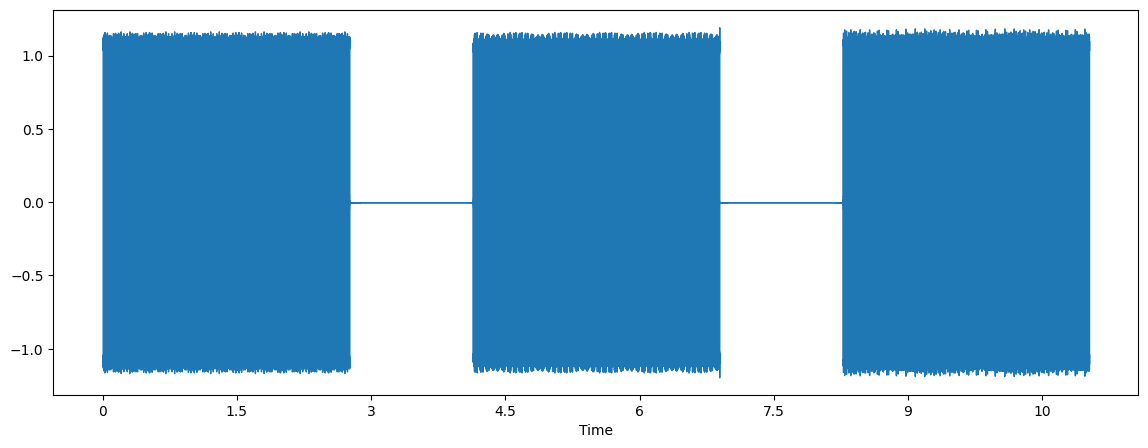

In [83]:
#dtmf.wav
import librosa
import numpy as np
import scipy
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib
dtmf, dtmf_sr = librosa.core.load("resources_dtmf.wav")
print(f"Len is {len(dtmf)}. Sample rate is {dtmf_sr}")
player = ipd.Audio(dtmf, rate=dtmf_sr)
ipd.display(player)
draw_waveform(dtmf, sr=dtmf_sr)

Построим спектрограмму:

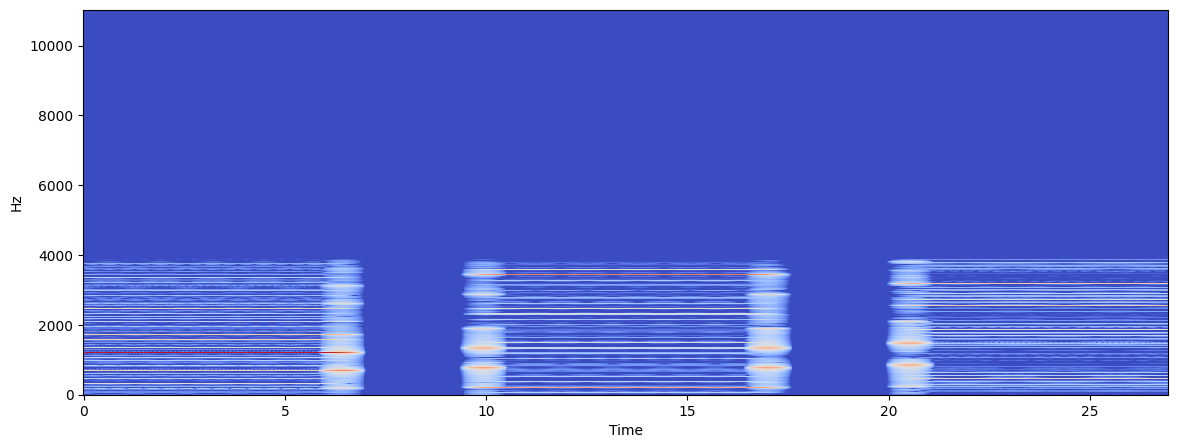

In [84]:
librosa_result = librosa.stft(dtmf, n_fft=dtmf_sr//2, hop_length=200, window='hann', center=False)
draw_stft(librosa_result, dtmf_sr)

### 1 число

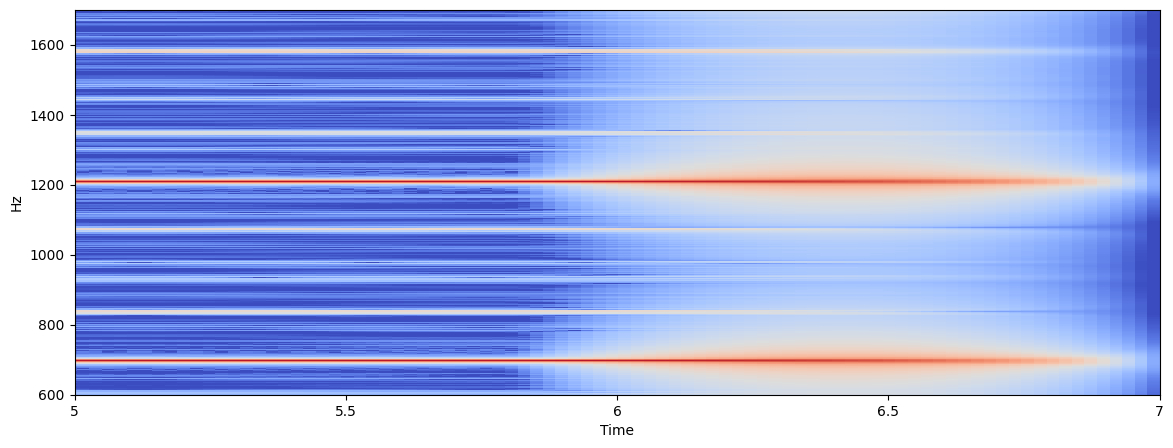

In [85]:
draw_stft(librosa_result, dtmf_sr, x_lim = [5,7], y_lim = [600,1700])

Видим 2 частоты: одна в районе 700Гц, вторая - чуть больше 1200Гц, значит это цифра 1

### 2 число

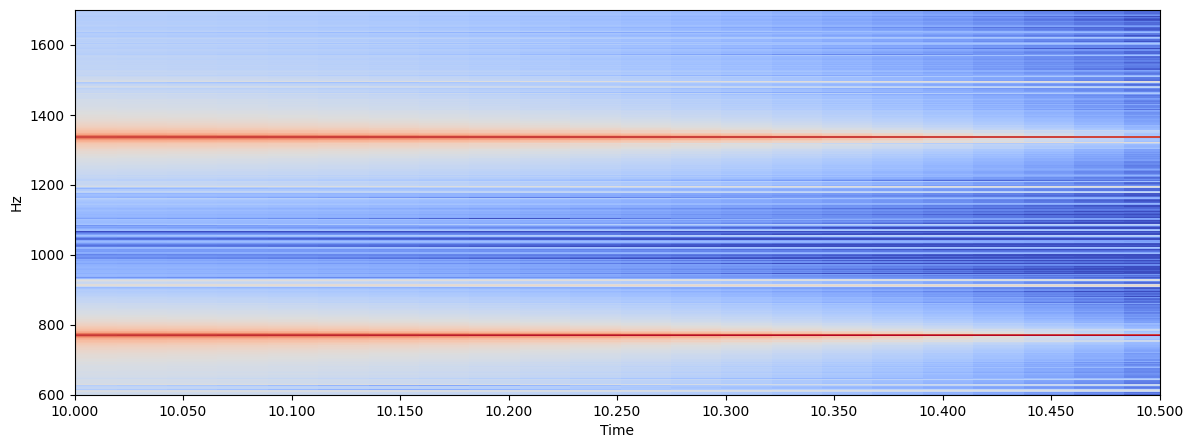

In [86]:
draw_stft(librosa_result, dtmf_sr, x_lim = [10,10.5], y_lim = [600,1700])

Видим 2 частоты: одна в районе 750-800Гц, вторая - чуть больше 1350Гц, значит это цифра 5

### 3 число

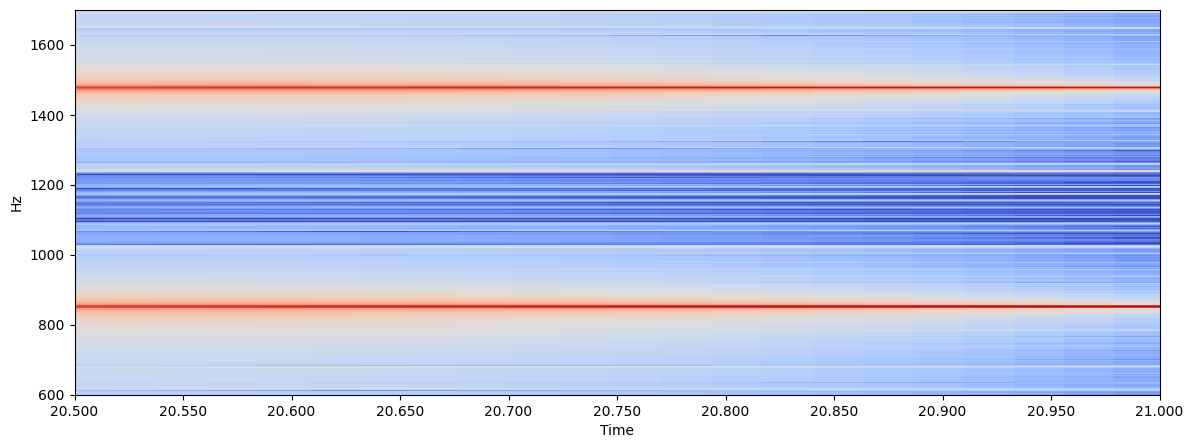

In [87]:
draw_stft(librosa_result, dtmf_sr, x_lim = [20.5,21], y_lim = [600,1700])

Видим 2 частоты: одна в районе 1450-1500Гц, вторая - примерно 850Гц, значит это цифра 9

### Тест

In [88]:
# phone_number = [first: int, second: int, third: int]
phone_number = [1, 5, 9]

In [89]:
assert type(phone_number) == list or type(phone_number) == np.ndarray, \
        f"Wrong answer type. Expected list or numpy array. Got {type(phone_number)}"
assert len(phone_number) == 3, \
        f"Wrong len {len(phone_number)}."
assert round(np.mean(phone_number)) == 5 and round(np.var(phone_number)) == 11 , \
        f"Wrong number"
assert hashlib.md5(''.join(map(str, phone_number)).encode()).hexdigest() == "140f6969d5213fd0ece03148e62e461e", \
        f"Wrong hash. How did you pass mean/var test?"
print("Correct!")

Correct!
